Proyecto: Evaluación de coches
===
Autores: Lidia Concepción Echeverría y Francisco Ponce Belmonte
---

Nuestro dataset contiene como atributos una serie de características de un coche y como resultado una evaluación del coche en su conjunto (no aceptable, aceptable, bueno y muy bueno). El objetivo de nuestro proyecto consiste en analizar esta evaluación subjetiva y poder predecir nuevas evaluaciones sobre otros coches, dadas sus características.

Los atributos de los que disponemos para analizar el dataset, son los siguientes (en orden):
* __Buying__: precio de compra del coche. Sus valores se dividen en [v-high, high, med, low].
* __Maint__: precio de mantenimiento. Sus valores se dividen en [v-high, high, med, low].
* __Doors__: número de puertas. Sus valores se dividen en [2, 3, 4, 5-more].
* __Persons__: número de pasajeros. Sus valores se dividen en [2, 4, more].
* __Lug-boot__: tamaño del maletero. Sus valores se dividen en [small, med, big].
* __Safety__: seguridad estimada del coche. Sus valores se dividen en [low, med, high].

La proporción de los resultados de la valoración en la muestra es de:
* __Unacceptable__ (inaceptable): 1210, (70.023 %) 
* __Acceptable__ (aceptable): 384, (22.222 %) 
* __Good__ (bueno): 69, (3.993 %)
* __Very Good__ (muy bueno): 65, (3.762 %) 

In [53]:
%matplotlib notebook
import csv
import pandas as pd
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
from pandas.io.parsers import read_csv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

A la hora de cargar los datos debemos tener en cuenta que el dataset se encuentra ordenado, por lo que haremos dos cargas distintas ya que para la validación de nuestro algoritmo nos interesa que esté desordenado, y de esta forma se evite el sesgo.

In [54]:
def load_data(filename):
    data = pd.read_csv(filename, header=None, delimiter=',').values
    attrnum = data.shape[1]-1
    return data[:, :attrnum], data[:, attrnum]

Al disponer de valores discretos y no numéricos, hemos utilizado la función factorize de pandas, para poder trabajar con ellos de forma más sencilla.

In [55]:
data, y = load_data('car.csv')
y, label = pd.factorize(y)

for i in range(data.shape[1]):
    data[:,i], labels= pd.factorize(data[:,i])

data = data.astype('float64')
y = y.astype('float64')
y = y.reshape(len(y),1)
label

array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

In [56]:
unos = np.full((y.shape[0],1),1)
th =np.zeros((7,1))
x = np.append(unos.astype('float64'), data, axis=1)

OneVsAll
===
Como primer abordaje al dataset, y sabiendo que se trata de un problema de clasificación, nos hemos decantado por utilizar el método OneVsAll, visto en la primera parte de la práctica 3. De esta forma, podemos entrenar múltiples clasificadores, uno por cada resultado posible. 

Además de la función OneVsAll, hemos incluido las funciones requeridas de la misma práctica para que éste funcione.

In [5]:
def sigmoide(z):
    s = np.dot(z,-1)
    e = np.exp(s)
    d = 1 + e
    return 1/d

In [6]:
def coste(th, x, y, lamda=1):
    g = sigmoide(np.dot(x,th))
    log1 = np.log(g)
    log2 = np.log(1-g)
    tr1 = np.dot(np.transpose(log1),y)
    tr2 = np.dot(np.transpose(log2),(1-y))
    c = -(tr1+tr2)/len(y)
    s = np.sum(th**2)/(2*len(y))
    return c + lamda*s

In [7]:
def lrgradientReg(theta,X,y, reg):
    m = y.size
    h = sigmoide(X.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*X.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [8]:
def oneVsAll(X, y, num_etiquetas, reg=0):
    matriz = []
    calificacion = np.zeros((num_etiquetas,X.shape[0]))
    th = np.zeros((7,1))
    for i in range(num_etiquetas):
        c = np.isin(y,i)
        result = opt.fmin_tnc(func=coste, x0=th, fprime=lrgradientReg, args=(X, c*1,reg))
        matriz.append(result[0])
    j = np.dot(matriz,np.transpose(X))
    for u in range(len(X)):
        calificacion[np.argmax(j[:,u])][u] = 1
    return np.transpose(calificacion), np.asarray(matriz).T

In [9]:
def testeo(y, f):
    result = np.argmax(f,axis=1).reshape(f.shape[0],1)   
    result = (result == (y))*1
    porcentaje = (sum(result)*100) / y.shape[0]
    return result, porcentaje

In [10]:
def seleccion(x, y, valor):
    matriz_x = []
    matriz_y = []
    for i in range(len(y)):
        if(y[i] == valor):
            matriz_x.append(x[i])
            matriz_y.append(y[i])
    return np.array(matriz_x), np.array(matriz_y)

In [11]:
percent_train = 0.8

x0, y0 = seleccion(x,y, 0)
x1, y1 = seleccion(x,y, 1)
x2, y2 = seleccion(x,y, 2)
x3, y3 = seleccion(x,y, 3)

x0train = x0[:int(x0.shape[0] * percent_train)]
x1train = x1[:int(x1.shape[0] * percent_train)]
x2train = x2[:int(x2.shape[0] * percent_train)]
x3train = x3[:int(x3.shape[0] * percent_train)]

y0train = y0[:int(y0.shape[0] * percent_train)]
y1train = y1[:int(y1.shape[0] * percent_train)]
y2train = y2[:int(y2.shape[0] * percent_train)]
y3train = y3[:int(y3.shape[0] * percent_train)]

x0val = x0[int(x0.shape[0] * percent_train):]
x1val = x1[int(x1.shape[0] * percent_train):]
x2val = x2[int(x2.shape[0] * percent_train):]
x3val = x3[int(x3.shape[0] * percent_train):]

y0val = y0[int(y0.shape[0] * percent_train):]
y1val = y1[int(y1.shape[0] * percent_train):]
y2val = y2[int(y2.shape[0] * percent_train):]
y3val = y3[int(y3.shape[0] * percent_train):]

xtrain = np.concatenate((x0train,x1train,x2train,x3train))
ytrain = np.concatenate((y0train,y1train,y2train,y3train))

xval = np.concatenate((x0val,x1val,x2val,x3val))
yval = np.concatenate((y0val,y1val,y2val,y3val))

In [12]:
regs = [0, 0.1, 1, 10, 100, 1000]

for i in regs:
    f, matriz =oneVsAll(xtrain,ytrain,4,i)
    print("Término de regularización: ", i)
    print("Resultados: ", testeo(ytrain,f)[1][0])
    print()

Término de regularización:  0
Resultados:  83.86396526772793

Término de regularización:  0.1
Resultados:  83.06801736613603

Término de regularización:  1
Resultados:  81.83791606367583

Término de regularización:  10
Resultados:  77.71345875542691

Término de regularización:  100
Resultados:  73.22720694645442

Término de regularización:  1000
Resultados:  70.04341534008682



Como podemos observar tras múltiples pruebas, cuanto menor es el término de regularización, mayor es el porcentaje de acierto. A medida que crece el término, el porcentaje de aciertos termina coincidiendo con el porcentaje de casos Inaceptables. Al ser el caso con mayor porcentaje, el clasificador identifica como válida una solución en la que todos los coches sean inaceptables.

Comprobación curva aprendizaje
==

Una vez cargamos los datos de manera desordenada los dividimos en entrenamiento y validación para comprobar la efectividad de nuestro algoritmo

In [13]:
def curva_aprendizaje(x,y,xval,yval):
    pesos = []
    error = []
    val = []
    for i in range(len(x)):
        pesos.append(oneVsAll(x[0:i+1],y[0:i+1],4,0.5)[1])
        error.append(np.sum(np.square(np.dot(x[0:i+1],pesos[i]) - y[0:i+1]))/(2*(i+1)))
        val.append(np.sum(np.square(np.dot(xval,pesos[i]) - (yval)))/(2*len(xval)))
    return error, val

In [14]:
error, val = curva_aprendizaje(xtrain,ytrain,xval,yval)

<IPython.core.display.Javascript object>


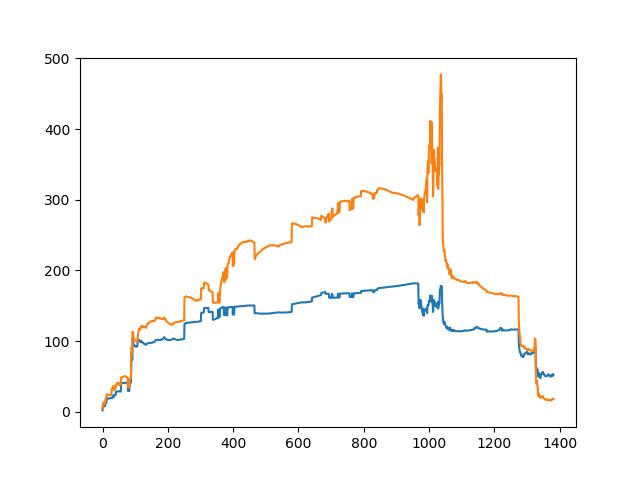

In [15]:
plt.figure()
plt.plot(range(len(xtrain)),np.asarray(error).T)
plt.plot(range(len(xtrain)),np.asarray(val).T)

Usando el metodo de propagación con RN

In [57]:
def pesosAleatorios(L_in, L_out):
    e_ini = 0.12
    pesos = np.random.uniform(-e_ini,e_ini,size=(L_out, L_in+1))
    return pesos

In [58]:
theta1 = pesosAleatorios(6,5)
theta2 = pesosAleatorios(5,4)

In [59]:
def propagacion (x,th):
    a = []
    unos = np.full((x.shape[0],1),1)
    for i in range(len(x)):
        z = np.dot(x[i],np.transpose(th))
        a.append(sigmoide(z))

    return np.append(unos,a, axis = 1)

In [60]:
f = propagacion(x,theta1)
f2 = propagacion(f,theta2)

In [61]:
f = np.copy(f2[:,1:])

In [62]:
testeo(y,f)[1][0]

3.9930555555555554

Utilizando RN con retropropagación.

In [63]:
def backprop (params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, reg ):
    th1 = np.reshape(params_rn [:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    th2 = np.reshape(params_rn [num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    
    X = np.concatenate((np.ones([X.shape[0],1]),X),axis=1)    
    
    p = prop(X,th1,th2).T

    coste = coste_reg(p, Y, th1, th2, num_etiquetas, reg)
    grad = retro_prop(X, Y, th1, th2, reg, num_etiquetas)

    return coste, grad

In [64]:
def coste_no_reg(h,Y,num_etiquetas):  
    c = 0
    for i in range(num_etiquetas):
        y = (Y==i+1)*1
        c += sum(-y*(np.log(h[i])) - (1-y)*(np.log(1-h[i])))
        
    return c / Y.shape[0]

In [65]:
def coste_reg(h, Y, th1, th2, num_etiquetas, reg):
    m = Y.shape[0]
    th1[0] = 0
    th2[0] = 0
    c = coste_no_reg(h,Y,num_etiquetas)
    c += (sum(sum(th1**2)) + sum(sum(th2**2))) * (reg/m*2)
       
    return c

In [66]:
def deriv_sig(Z):
    sig = sigmoide(Z)
    return sig * (1 - sig)

In [67]:
def prop(X,th1,th2): 
    a1 = sigmoide(np.dot(X, th1.T))
    a1 = np.concatenate((np.ones([a1.shape[0],1]),a1),axis=1)
    a2 = sigmoide(np.dot(a1, th2.T))
    
    return a2

In [68]:
def retro_prop(X, Y, th1, th2, reg, num_etiquetas):    
    a1 = sigmoide(np.dot(X, theta1.T))
    a2 = np.concatenate((np.ones([a1.shape[0],1]),a1),axis=1)
    a3 = sigmoide(np.dot(a2, theta2.T))
    
    y = np.zeros((Y.shape[0],num_etiquetas))    
    for i in range (num_etiquetas):
        y[i, Y[i]-1] = 1 
        
    s3 = a3 - y
    s2 = np.dot(s3, th2)[:,1:]
    s2 = s2 * deriv_sig(np.dot(X, th1.T))
    delta1 = np.dot(s2.T, X)
    delta2 = np.dot(s3.T, a2)

    m = Y.shape[0]
    grad1 = delta1/m
    grad2 = delta2/m
    
    th1[:,1]=0
    th2[:,1]=0
    grad1 = grad1+(reg/m)*th1
    grad2 = grad2+(reg/m)*th2
    
    return np.concatenate((np.ravel(grad1),np.ravel(grad2))) 

In [69]:
def aprendNN(X, Y, params, num_entradas, num_ocultas, num_etiquetas, lamb, maxiter):
    fmin = opt.minimize(fun=backprop, x0=params, 
                        args=(num_entradas, num_ocultas, num_etiquetas, X, Y, lamb),
                        method='TNC', jac=True, options={'maxiter': maxiter})
    
    theta1 = np.reshape(fmin.x [:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(fmin.x [num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    
    X = np.concatenate((np.ones([X.shape[0],1]),X),axis=1)
    
    res = prop(X,theta1,theta2)   
    result = np.argmax(res,axis=1)     
    result = (result == (Y))*1
    
    porcentaje = (sum(result)*100) / Y.shape[0]

    return porcentaje

A partir de 33 iteraciones el valor alcanza su máximo por otro lado hemos comprobado que el valor de regularización afecta de manera anecdótica.

In [29]:
theta1 = pesosAleatorios(6,5)
theta2 = pesosAleatorios(5,4)

In [30]:
th1_opt = theta1
th2_opt = theta2

In [70]:
# Theta1 e s de dimensión 5 x 7
# Theta2 e s de dimensión 4 x 6
y = np.array(y.T)[0]    
theta_vec = np.concatenate((np.ravel(theta1),np.ravel(theta2)))
num_entradas = theta1.shape[1]-1
num_ocultas = theta1.shape[0]

In [73]:
aprendNN(data.astype('int'),y.astype('int'),theta_vec,num_entradas, num_ocultas, 4, 1, 2000)

70.02314814814815